In [1]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, '..')

from pybandstructure import *

import graphene as gr

## Parameters

In [2]:
#################### graphene parameters #######################################
#distances in nm, energies in eV
E_SQUARED = 1.4399764 #[eV * nm] square of elementary charge 
a = 1 #[nm] lattice constant 
t = -1 #[ev] hopping
#################################################################################
density = 0.02 #electron density in [nm^-2]
temperature = 0.01 #k_B T [eV]
#################### computational parameters ##################################
n_sites = 40# number of unit cells of the crystal in one direction !must be multiple of 4!
eta = 0.1 #energy smoothing [eV]

# Model

In [3]:
H = t * Momentum_Conserving_Operator(matrices = [np.identity(1)],
                                 coefficients = [lambda k : 2 * np.cos(k[0]*a) + 2 * np.cos(k[1]*a)])
px = t * Momentum_Conserving_Operator(matrices = [np.identity(1)],
                                 coefficients = [lambda k : -2*a * np.sin(k[0]*a) + 2 * np.cos(k[1]*a)])
py = t * Momentum_Conserving_Operator(matrices = [np.identity(1)],
                                 coefficients = [lambda k : 2 * np.cos(k[0]*a) - 2*a * np.sin(k[1]*a)])

# Geometry

In [4]:
######################### Point group ###########################################
point_group = Point_Group.dihedral_group(
    n = 4,
    theta0 = 0)
point_group = Point_Group.trivial_group(space_dimension=2)
#################################################################################
lattice_geometry = Crystal_Geometry(reciprocal_lattice_basis = np.array([[2. * np.pi/a,0],[0, 2. * np.pi/a]]), 
                                    point_group = point_group)
######
special_points = {"$\Gamma$": (0, 0),
                "$X$": (n_sites// 2, 0),
                "$M$": (n_sites // 2, n_sites // 2),}

# Reciprocal space sampling

In [5]:
##################### k-sample ##################################################
########## Default u.c. ##########################
#k_sample = Unit_Cell_Sample.default_unit_cell(basis_vectors= lattice_geometry.reciprocal_lattice_basis, 
#                                              denominator=n_sites,
#                                              special_points = special_points)
k_sample = Unit_Cell_Sample.wigner_seitz_cell(basis_vectors= lattice_geometry.reciprocal_lattice_basis,
                                              denominator=n_sites, special_points=special_points)
########## Reduced sample ########################
#k_sample = Unit_Cell_Sample.irreducible_wigner_seitz_cell(
#    basis_vectors= model['reciprocal_lattice_vectors'].basis_vectors, 
#    denominator=n_sites, 
#    point_group = point_group, 
#    special_points = special_points)
##### Precompiled sample #########################
#k_sample = Unit_Cell_Sample.irreducible_sample(name = '2D_Square_D4',
#                                              basis_vectors= lattice_geometry.reciprocal_lattice_basis,
#                                              denominator=n_sites)
#########################################################
####################### q-sample ########################
#q_sample = Unit_Cell_Sample.default_unit_cell(basis_vectors= lattice_geometry.reciprocal_lattice_basis,
#                                              denominator=n_sites,
#                                              special_points = special_points)
#q_sample = Unit_Cell_Sample.wigner_seitz_cell(basis_vectors= lattice_geometry.reciprocal_lattice_basis,
#                                              denominator=n_sites, special_points=special_points)
q_sample = Unit_Cell_Sample.irreducible_sample(name = '2D_Square_D4',
                                              basis_vectors= lattice_geometry.reciprocal_lattice_basis,
                                              denominator=n_sites)
#########################################################
####################### G-sample ########################
G_sample = Sample.lattice_sample(basis_vectors=lattice_geometry.reciprocal_lattice_basis,
                                 cut_off= 0.0001/a)

# Plot samplings

..\pybandstructure\sample\sample.py:584: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
..\pybandstructure\sample\sample.py:584: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


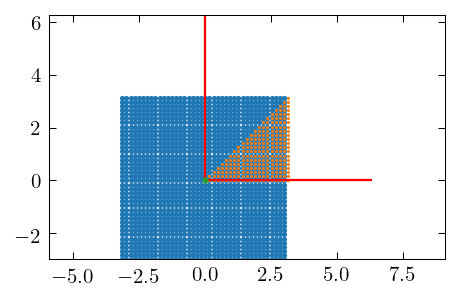

In [6]:
k_sample.plot(ms = 2.5)
q_sample.plot(ms = 1.5)
G_sample.plot(ms = 3)

In [7]:
k_sample(6)

{'index': 6, 'operation': 0, 'integer_part': (0, 0)}

In [8]:
density_operator = []
density_operator.append(
    Operator(matrices = [np.identity(1, dtype = complex)], coefficients = [lambda k,q,integer_part,operation : 1 if integer_part ==(0,0) else 0], momentum_conserving = False, hermitian=False)
)

In [9]:
band_structure = Band_Structure.from_hamiltonian(k_sample = k_sample, 
                                                 q_sample = q_sample,
                                                 G_sample = G_sample,
                                                 hamiltonian = H,
                                                 momentum_operator = [px,py],
                                                 density_operator = density_operator,
                                                 degeneracy = 1,
                                                 zero_filling = 0,
                                                 density = density,
                                                 temperature = temperature)

In [10]:
tblg = Crystal(band_structure=band_structure, geometry=lattice_geometry, eta = eta)

In [11]:
tblg.band_structure.compute_bands()

100%|███████████████████████████████████████████████████████████████████████████| 1600/1600 [00:00<00:00, 10389.75it/s]


In [12]:
tblg.band_structure.compute_momentum_matrix()

100%|███████████████████████████████████████████████████████████████████████████| 1600/1600 [00:00<00:00, 16495.03it/s]


In [13]:
tblg.band_structure.compute_density_matrix()

100%|██████████████████████████████████████████████████████████████████████████████| 1600/1600 [00:29<00:00, 54.48it/s]


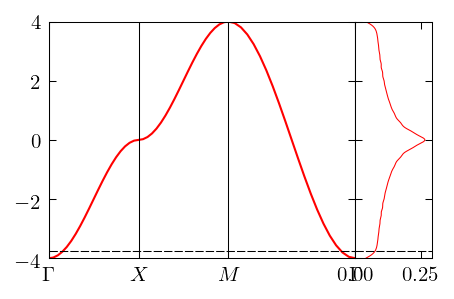

In [14]:
e_lims = -np.amax(tblg.band_structure.energies),np.amax(tblg.band_structure.energies) #energy limits for the figure
e_vals = np.linspace(*e_lims,num=200)
dosvals = tblg.dos(e_vals, shape = 'fermi')
plt.figure()
plt.axes([0.2,0.2,0.6,0.75])
_ = tblg.band_structure.plot([r'$\Gamma$', r'$X$', r'$M$',r'$\Gamma$'], c='r',emin = e_lims[0], emax=e_lims[1])
plt.ylim(e_lims[0],e_lims[-1])
#plt.yticks(np.arange(-0.01,0.03,0.005))
ax = plt.axes([0.8,0.2,0.15,0.75])
ax.yaxis.set_label_position("right")

ax.set_yticklabels([])
plt.ylim(e_lims[0],e_lims[-1])
plt.xlim(0,1.1*np.amax(dosvals))
plt.plot(dosvals ,e_vals, c='r',lw=0.5)
plt.plot([0,1.1*np.amax(dosvals)],[tblg.band_structure.chemical_potential,tblg.band_structure.chemical_potential],'--',c='k', lw=0.5)

In [15]:
tblg.eta = 0.1
tblg.temperature = 1

In [16]:
chi = np.zeros([len(q_sample)], dtype = float)

for i in range(len(q_sample)):
    chi[i] =np.real(tblg.static_polarization(q_index = i, G_index = 0, G1_index = 0))
   

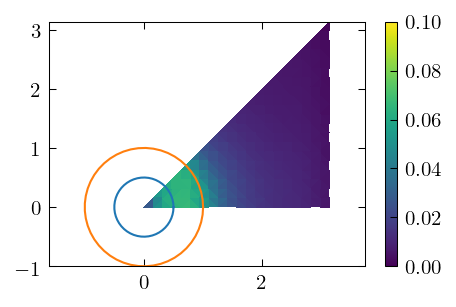

In [17]:
plt.tripcolor(
q_sample.coords[:,0],
q_sample.coords[:,1],
-chi,
vmin=0,
vmax = .1
)
plt.colorbar()
plt.axis('equal')
theta = np.linspace(0,2*np.pi)
kf = np.sqrt(4 * np.pi * tblg.band_structure.density)
plt.plot(kf *np.cos(theta), kf *np.sin(theta))
plt.plot(2 * kf *np.cos(theta), 2 * kf *np.sin(theta))

In [18]:
contour = q_sample.contour([r'$\Gamma$', r'$X$', r'$M$',r'$\Gamma$'])

In [19]:
def chi_2deg(q):
    return 1- np.heaviside(q-2,0.5) * np.sqrt(q**2-4+0.j)/q

In [20]:
plt.xticks(contour['x'][contour['vertices']], [r'$\Gamma$', r'$X$', r'$M$',r'$\Gamma$'])
plt.plot(contour['x'], -chi[contour['indices']],'o')
plt.plot(contour['x'], np.ones_like(contour['x'])*tblg.dos(tblg.band_structure.chemical_potential,shape = 'fermi'))
plt.plot(contour['x'], np.ones_like(contour['x'])*(-1/(4 *np.pi *a**2 *t)),'--')
plt.plot(contour['x'], -1/(4 *np.pi*a**2*t) * chi_2deg(np.sqrt(np.sum((q_sample.coords[contour['indices'],:])**2, axis=1))  /(np.sqrt(4 * tblg.band_structure.density *np.pi))))
plt.ylim(0,0.5)

C:\Users\Windows\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\Windows\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0, 0.5)